## Part 3 Systematics

Other tutorials
* See also [Hannu's tutorial](https://github.com/hpparvi/exo_tutorials/blob/master/01_broadband_parameter_estimation.ipynb)
* Bayesian and Frequentist Statistics Explained [J. van der Plas blog](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
* Data Analysis Recipes: Fitting a model to data ([Hogg et al.](https://arxiv.org/abs/1008.4686))

In [19]:
#check python version
!python --version

Python 3.6.2 :: Continuum Analytics, Inc.


In [20]:
#check environment
import os
os.environ['CONDA_DEFAULT_ENV']

'py3'

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=18

## import data

In [22]:
from glob import glob

datadir = '.'
path    = os.path.join(datadir,'TRAPPIST*.csv')
file_list = glob(path)
file_list = sorted(file_list)
file_list

['./TRAPPIST-1_rad13_temp1.csv', './TRAPPIST-1_rad13_temp2.csv']

In [23]:
df=pd.read_csv(file_list[0], delimiter=',', parse_dates=True)
df = df.drop('Unnamed: 0',axis=1)

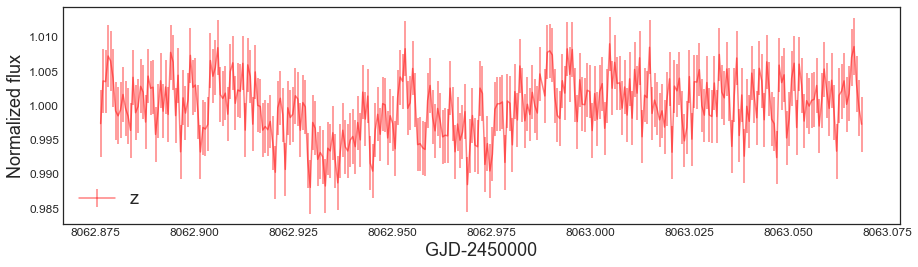

In [24]:
import matplotlib.pyplot as pl
%matplotlib inline

fig,ax = pl.subplots(1,1,figsize=(15,4))
    
time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]

ax.errorbar(time, flux, yerr=err, label="z",color="r", alpha=0.5)
ax.set_ylabel('Normalized flux', fontsize=fontsize)
              
pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('GJD-2450000', fontsize=fontsize)

## setting-up the transit model 

```
* t:     time
* k:     Rp/Rs: planet-star radius ratio (=k^2: transit depth)
* u1,u2: limb-darkening coefficients
* tc:    transit center
* P:     orbital period
* a_s:   a/Rs: scaled semi-major axis
* i:     inclination
* e:     eccentricity
* w:     argument of periastron
* c:     contamination factor
```

See transit parameters for HAT-P-44b at [exoplanets.org](http://exoplanets.org/detail/HAT-P-44_b)

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [25]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

from pytransit import MandelAgol

def transit_model_q(parameters, period, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * q1 : limb-darkening coefficient (for the linear term)
    * q2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    k,q1,q2,tc,a,b = parameters
    
    #compute inclination
    inc   = np.arccos(b/a)
    #convert u to q
    u1,u2 = q_to_u(q1, q2)
    #evaluate the model
    m = model.evaluate(time, k, (u1,u2), tc, period, a, inc)
    
    return m

In [32]:
import numpy as np
from astropy import units as u

#values come from S.Wang et al.(2017) 
_tc  = 8062.9449 
_P   = 6.099570 #pm 0.000091 (days)
_a   = 0.02818 #semimajor axis (AU)
_e  = 0.007 #pm 0.003
_Rp = 0.918 #pm0.039 (R_earth)

#from M.Gillon et al.(2017)
_b   = 0.12 #+0.11/-0.09
_inc = np.deg2rad(89.86) #+0.10/-0.12

_Rs = 0.117 #pm 0.0036(Rsun)
k_ = _Rpe/_Rs/u.Rsun.to(u.Rearth)

a_s_= _ae/_Rs/u.Rsun.to(u.au)

tc_0      = 8062.930


In [33]:
import limbdark as ld

teff, uteff = 2559,  50 #from M.Gillon(2017)
logg, ulogg = 4.39, 0.03 #from Exoplanets Data Explorer
feh, ufeh   = 0.04,  0.08 #from M.Gillon(2017)

ldc_list     = []
ldc_err_list = []

ldc = ld.claret("z*", teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
#ldc = u1_,u1err, u2_,u2err

#save in list
#u1,u2
ldc_list.append([ldc[0],ldc[2]]) #take first and third element of ldc 
#uncertainties
ldc_err_list.append([ldc[1],ldc[3]]) #take second and fourth element of ldc

## Optimizing transit parameters: Frequentist approach

### 1. Maximum Likelihood Estimation (MLE)

See part3; See part5 for Bayesian approach

In [34]:
ldc[0]

0.37330000000000002

In [35]:
import scipy.optimize as op

def obj(theta, p, t, f, err):
    '''
    objective function: chi-squared
    '''
    m = transit_model_q(theta, p, t)
    
    return np.sum(((m-f)/err)**2)

def rms(flux,flux_model):
    residual = flux-flux_model
    return np.sqrt(np.mean((residual)**2))

rms before: 0.0042
rms after: 0.0040



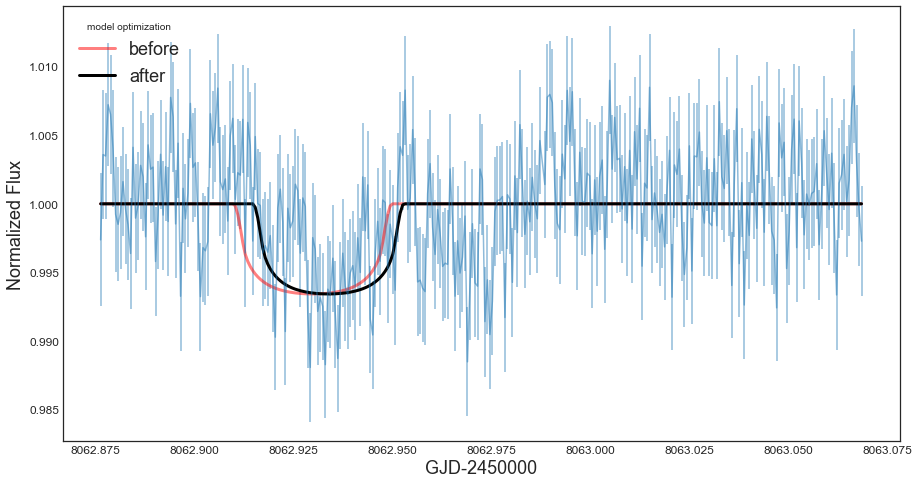

In [36]:
fig,ax = pl.subplots(1,1,figsize=(15,8))

optimized_transit_params = {} 
    
time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]
    
pl.errorbar(time, flux, yerr=err, alpha=0.5) 

#compute q from u found in limbdark
q1_,q2_ = u_to_q(ldc[0],ldc[2])

#compute flux before optimization
transit_params     = [k_,q1_,q2_,tc_0,a_s_,_b]
transit_model_before  = transit_model_q(transit_params, _P, time)
#rms before
rms_before = rms(flux,transit_model_before)
print('rms before: {:.4f}'.format(rms_before))
    
#optimize parameters
result = op.minimize(obj, transit_params, args=(_P, time, flux, err), method='nelder-mead')
    
#compute flux after optimization
transit_params_after     = np.copy(result.x)
transit_model_after  = transit_model_q(transit_params_after, _P, time)
#rms after
rms_after = rms(flux,transit_model_after)
print('rms after: {:.4f}\n'.format(rms_after))
    
#plot transit models
#before (faint red)
ax.plot(time, transit_model_before, 'r-', lw=3, alpha=0.5)
#after (black)
ax.plot(time, transit_model_after, 'k-', lw=3, alpha=1)
ax.legend(fontsize=fontsize)
    
#dict of optimized transit parameters to be used later
optimized_transit_params = transit_params_after
    
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('GJD-2450000', fontsize=fontsize)
ax.legend(['before','after'], title='model optimization',fontsize=fontsize)

In [37]:
optimized_transit_params

array([  7.19322132e-02,   8.48977929e-01,   2.02572299e-01,
         8.06293397e+03,   5.43809851e+01,   1.20000517e-01])

## Optimizing transit parameters: Bayesian approach

See part6.

---

## Modeling systematics

Transit light curve contains various information. Aside from the transit signal, it also (generally) contains systematic noise and photometric noise.

![img](images/modeling.png)

Systematics is a catch-all term that accounts for the noise in the light curve except photometric noise. Systematics is largely composed of (but not limited to):

* stellar variability
* instrumental noise (detector, tracking problems, etc.)
* atmospheric variability
* etc.

What we would like to do is to model all of them together and at the same time (i.e simultaneous) to get the best fit parameters; not model them separately by removing systematic first and then fitting for transit parameters (or vice-versa). We will show how to do simultaneous modeling in the mcmc part (part6) of this tutorial series. 

Let's try to understand first how to model the systematics separately from the transit signal. It must be emphasized rightaway that modeling transit and systematics separately is usually wrong because we do not have complete complete understanding of either the transit or systematics component of the light curve.

For now, let's assume that the transit parameters we obtained after optimization are correct. We will remove the transit signal from the light curve so that the residual signal is assumed to contain the systematics only.

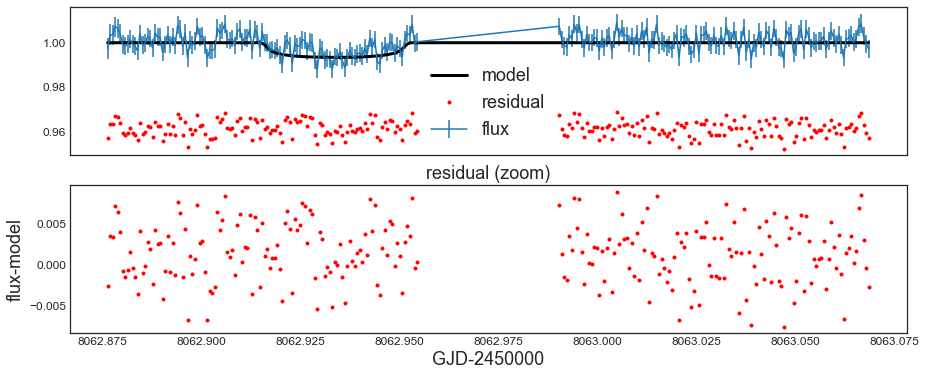

In [27]:
time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]

#flux model with optimized transit parameters
transit_model = transit_model_q(optimized_transit_params, _P, time)

fig,ax = pl.subplots(2,1,figsize=(15,6), sharex=True)

ax[0].errorbar(time, flux, yerr=err)
ax[0].plot(time, transit_model, 'k-', lw=3, label='model')


#plot residual
offset= 0.96
resid = flux-transit_model
ax[0].plot(time, resid+offset, 'r.', label='residual', lw=2)
ax[0].legend(fontsize=fontsize)

#plot residual again, but in a new axis
ax[1].plot(time, resid, 'r.', lw=2)
rms(flux,transit_model)
ax[1].set_title('residual (zoom)',fontsize=fontsize)
ax[1].set_ylabel('flux-model',fontsize=fontsize)
ax[1].set_xlabel('GJD-2450000', fontsize=fontsize)

## computing systematics parameters: Frequentist approach

We can model the systematics in two general ways:
* [parametric](https://en.wikipedia.org/wiki/Parametric_model)
* [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics)

A parametric model basically means the model has given finite set of parameters. A common example of a parametric systematics model is a linear combination of constant coefficients and auxiliary observables:
$$
y_i=w_0+\sum_{i=0}w_iX_i \\
y_i=y_{\rm{data}}-y_{\rm{transit\;model}} = w_0+w_1X_1+ \ldots + w_nX_n
$$
where $y_i$ is the function we want to model (e.g. residual which contains systematics), $X_i$ is the set of auxiliary observables (e.g. centroid position of target, airmass, etc.), and $w_i$ is the set of coefficients (or weights) of $X_i$.

Using Maximum Likelihood Estimation (MLE) to compute/optimize $w$ is not recommended (and will most likely fail) because we don't have good guesses for the initial values of the constant coefficients. Remember in our transit modeling, we have good guesses for limb-dakening coefficients, transit center, etc.

A non-parametric model basically means the model has infinite parameters and usually has no auxiliary parameters needed to model the data. An example of a non-parametric model used frequently to model transit light curves is the [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) model which we will not disccuss in this tutorial (let's ask John!). For simplicity, a simpler non-parametric model using Radial Basis Function is shown (in the Appendix) to compare with the result of the parameteric modeling.

---

### least-squares/ $\chi^2$-square (Linear algebra)

![img](images/linalg.jpg)

Let's implement ordinary least square/ chi-square using linear algebra. 

Our aim is to compute the weights $w$ (or coefficients of the systematics model):
$$
y_i=w_0+\sum_{i=0}w_iX_i
$$
or in vector form:
$$
y= X \cdot w
$$

Solving for $w$,
$$
X^T \cdot y = X^T \cdot X \cdot w \\
(X^T \cdot X)^{-1} \cdot X^T \cdot y = w
$$
where $y$ is the function we want to model (e.g. residual which contains systematics) and $X$ is the "[design matrix](https://en.wikipedia.org/wiki/Design_matrix)" that contains auxiliary the observables.

$X$ can be composed of any auxiliary observables such as
```
* target centroid           e.g. dx(pix), dy(pix)
* airmass
* sky background            e.g. sky(ADU)
* fwhm                      e.g. fwhm(pix)
* peak flux                 e.g. peak(ADU)
* error or flux uncertainty e.g. err(r=11.0)
* color                     e.g. flux_g/flux_r


* powers of [param]         e.g. dx^2, dy^2
* cross-term                e.g. dx*dy
* etc.
```

We can use the `numpy` functions below to solve the equation above. 
* `np.dot ` for dot product
* `np.linalg.inv ` for inverse
* `[vector].T ` for transpose

However, we will use `np.linalg.solve` (instead of `np.linalg.inv`) to avoid problems related with matrices that cannot be inverted. See details in [StackOverflow](https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li).

Let's construct $X$ for the z-band for now.

In [28]:
df.columns

Index(['GJD-2450000', 'flux', 'err', 'airmass', 'sky', 'dx', 'dy'], dtype='object')

In [30]:
dx        = df['dx']
dy        = df['dy']
airmass   = df['airmass']
sky       = df['sky']
#fwhm      = df['fwhm(pix)']
#peak      = df['peak(ADU)']
err       = df['err']
flux      = df['flux']

### Simple systematics model

First, use only the shift/displace of centroids in the detector: dx and dy. We can concatenate the them using `np.c_`

In [31]:
X = np.c_[dx,dy]
#show the first 10 values
X[:10]

array([[-0.027, -2.954],
       [-0.084, -2.454],
       [-0.13 , -1.302],
       [-0.433,  0.046],
       [ 0.116, -1.458],
       [-0.694, -1.532],
       [-0.494, -2.036],
       [ 0.183, -0.653],
       [ 0.05 , -0.552],
       [-0.566, -1.874]])

Then, compute weights (coefficients) $w$ of systematic model using the residual.

In [32]:
resid  = flux-transit_model
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, resid))
w

array([-0.00022779, -0.00080042])

Note that the number of components of $w$ should be equal to the number of observables (or columns) in $X$

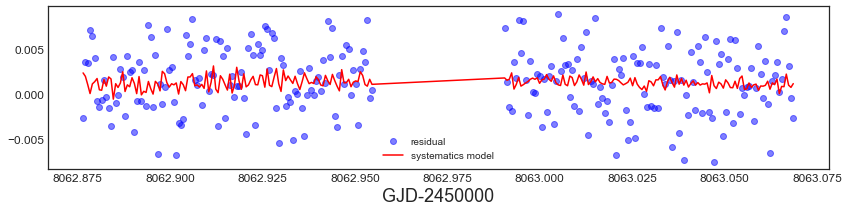

In [33]:
fig, ax   = pl.subplots(1,1,figsize=(14,3))
sys_model = np.dot(X,w)

ax.plot(time, resid, 'bo', alpha=0.5, label='residual')
ax.plot(time, sys_model, 'r-', label='systematics model')
ax.set_xlabel('GJD-2450000', fontsize=fontsize)
pl.legend()

Let's see more plots.

rms of residual:
0.0039
rms of residual w/o systematics:
0.0014


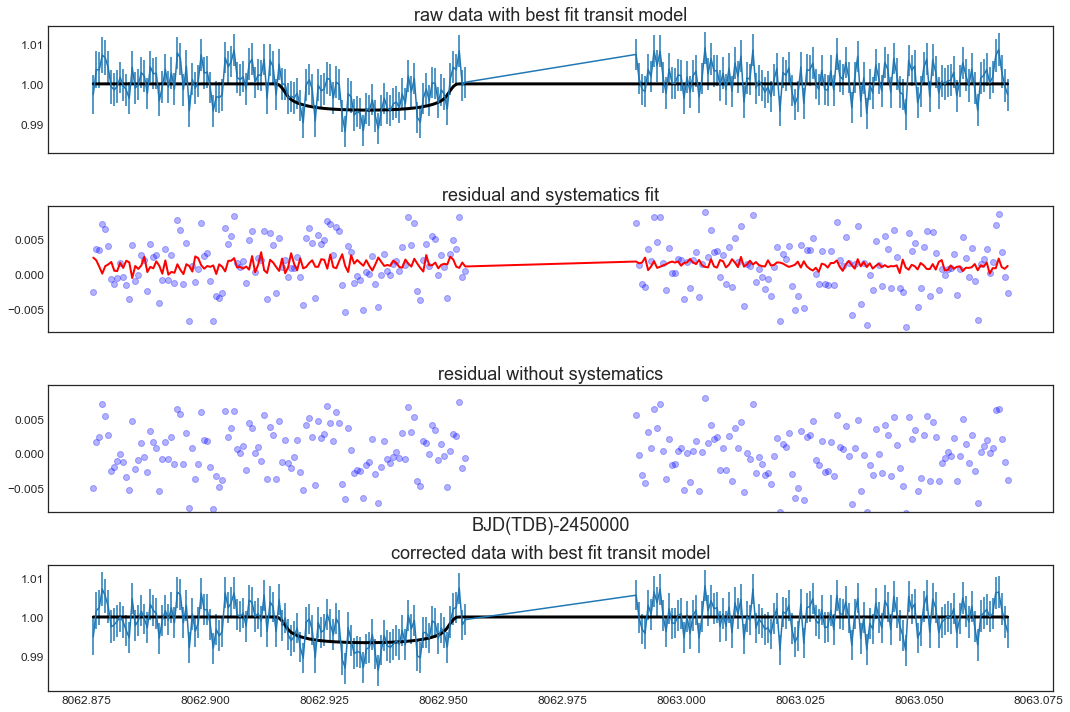

In [34]:
fig,ax = pl.subplots(4,1,figsize=(15,10), sharex=True)

#top: raw data
ax[0].errorbar(time, flux, yerr=err)
ax[0].plot(time, transit_model, 'k-', lw=3, label='model')
ax[0].set_title('raw data with best fit transit model', fontsize=fontsize)

#middle: residual
resid = flux-transit_model
ax[1].plot(time, resid, 'bo', alpha=0.3, label='residual')
ax[1].plot(time, sys_model, 'r-', lw=2, label='systematics')
ax[1].set_title('residual and systematics fit', fontsize=fontsize)

#bottom: residual without systematics
resid_wo_sys = flux-transit_model-sys_model
ax[2].plot(time, resid_wo_sys, 'bo', alpha=0.3)
ax[2].set_title('residual without systematics', fontsize=fontsize)
ax[2].set_ylim(*ax[1].get_ylim()) #make y-axis limits of ax[2] like in ax[1]
ax[2].set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)

#compute rms
rms1 = rms(flux, transit_model)
rms2 = rms(resid, resid_wo_sys)
print('rms of residual:\n{:.4f}'.format(rms1))
print('rms of residual w/o systematics:\n{:.4f}'.format(rms2))

#corrected lightcurve
ax[3].errorbar(time, flux-sys_model, yerr=err)
ax[3].plot(time, transit_model, 'k-', lw=3, label='model')
ax[3].set_title('corrected data with best fit transit model', fontsize=fontsize)
fig.tight_layout()

The systematic model (red line) above does not fit the residuals (blue points).

![img](images/monkey.gif)

Once stellar systematics is removed, the residual should in principle be pure random or uncorrelated noise (a.k.a. "white noise"). We can check is residual above contains only white noise by computing the autocorrelation of the residual.

We can visualize autocorrelation using `pandas.plotting.autocorrelation_plot`

To quote,

Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random, then one or more of the autocorrelations will be siginicantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% (dashed) confidence bands.

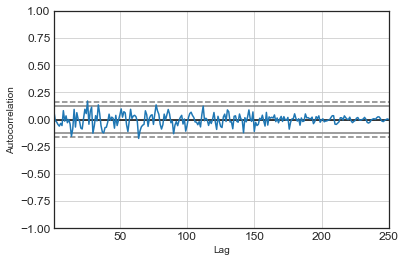

In [35]:
import pandas as pd

resid_wo_sys = flux - transit_model - sys_model
pd.plotting.autocorrelation_plot(resid_wo_sys)

Certainly, using `dx` and `dy` in $X$ is not enough because the autocorrelation plot above shows significant correlated noise still present in the residual. Let's try to use other set of auxiliary observables, aside from dx and dy.

What is the **best set** of auxiliary vector to use?

![img](images/auxvec.jpg)

There is no rule on the best/ correct auxiliary observable to put in $X$. But may be it is useful to use those vectors that are correlated with the data that we want to model. `seaborn` is another library with useful visualization. `seaborn.pairplot` can be used to quickly visualize correlation among variables as shown below.

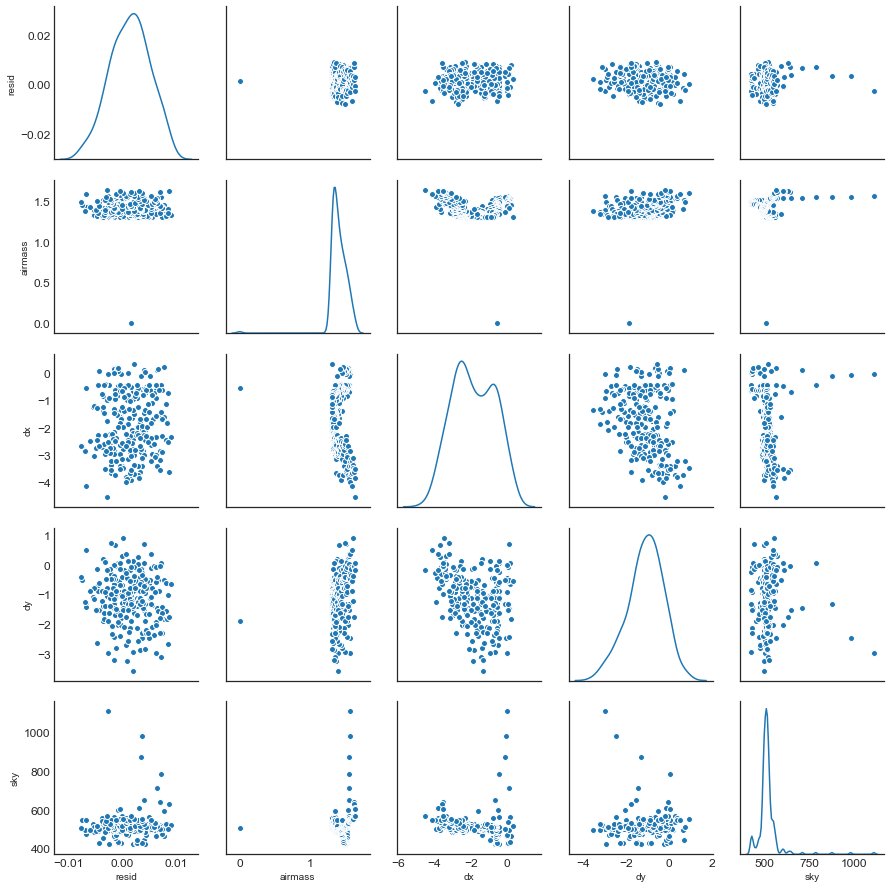

In [38]:
import seaborn as sb
sb.set_style('white')

df['resid']=resid #flux-transit_model
sb.pairplot(df.dropna(), 
            vars=['resid','airmass','dx','dy', 'sky'], 
            diag_kind='kde')

From the pairplots above, it seems reasonable to use airmass and sky; others appear to be uncorrelated with the residual. Let's do trial and error below until we get a significant reduction in rms error. We will also verify our result using autocorrelation plot.

### A better systematics model (?)

[Fukui et al. (2016)](https://arxiv.org/pdf/1610.01333.pdf) used color information (=ratio of glux in two bands e.g. flux_g/flux_r) in the systematics model. 

To include color information in $X$, we should first take note the number of data points in each band. They differ because the exposure time for MuSCAT r-band detector was set shorter (30-sec) than g-,and z-bands (60-sec) during the observation. Also, g-band has less data points because of the bad data removed in the beginning of this tutorial.

In [24]:
print('no. of data points:')
for b in bands:
    print('{}:\t{}'.format(b, len(data[b]['flux(r=11.0)'])))

no. of data points:
g:	375
r:	704
z:	376


Thus we will do binning or interpolation of fluxes of r- and z-band to make them of the same length as flux in g-band.

In [26]:
#set number of data points of r- and z-band equal to that of g-band:
bins = len(data['g'].index)
bins

375

In [27]:
def binning(x,y,bins):
    t=np.linspace(x[0],x[-1], bins)
    y=np.interp(x=t, xp=x, fp=y)
    return t, y

To make sure that that flux ratios will be computed correctly after binning, let's make another function.

In [28]:
def flux_ratios(x1, y1, x2, y2, bins):
    numerator   = binning(x1,y1,bins)[1] #get y-component only
    denominator = binning(x2,y2,bins)[1]
    return numerator/ denominator

In [29]:
#np.zeros(len(dx))+0.1
b  = 'z'
df = data[b]
flux = df[fluxcol]
dx   = df['dx(pix)']
dy   = df['dy(pix)']
airmass = df['airmass']
err  = df[errcol]
time = df.index

#compute flux ratios or color
color_zg = flux_ratios(time,flux,data['g'].index,
                       data['g'][fluxcol], 
                       bins=len(df))
color_zr = flux_ratios(time,flux,data['r'].index,
                       data['r'][fluxcol], 
                       bins=len(df))

vert_offset = np.ones_like(dx)

#make sure use correct transit model to compute the residual
transit_model = transit_model_q(optimized_transit_params[b], _P, time)

resid = flux-transit_model
X = np.c_[color_zg, color_zr, dy, err, vert_offset, time] # add more auxiliary vector here
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, resid))
w

array([  1.21276035e-01,   4.88639292e-01,   9.11490294e-05,
         1.39052884e+01,  -2.20451673e+02,   2.81805237e-02])

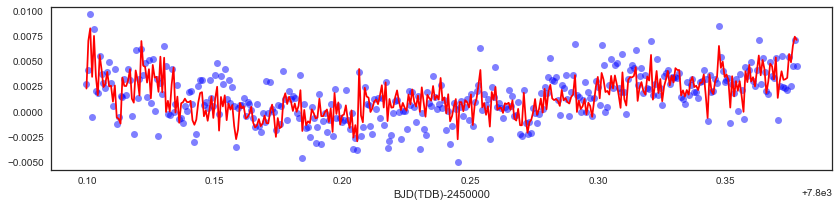

In [30]:
pl.style.use('seaborn-white')

fig, ax = pl.subplots(1,1,figsize=(14,3))
sys_model = np.dot(X,w)

ax.plot(time, resid, 'bo', alpha=0.5)
ax.plot(time, sys_model, 'r-')
ax.set_xlabel('BJD(TDB)-2450000')

rms of residual:
0.0028
rms of residual w/o systematics:
0.0025


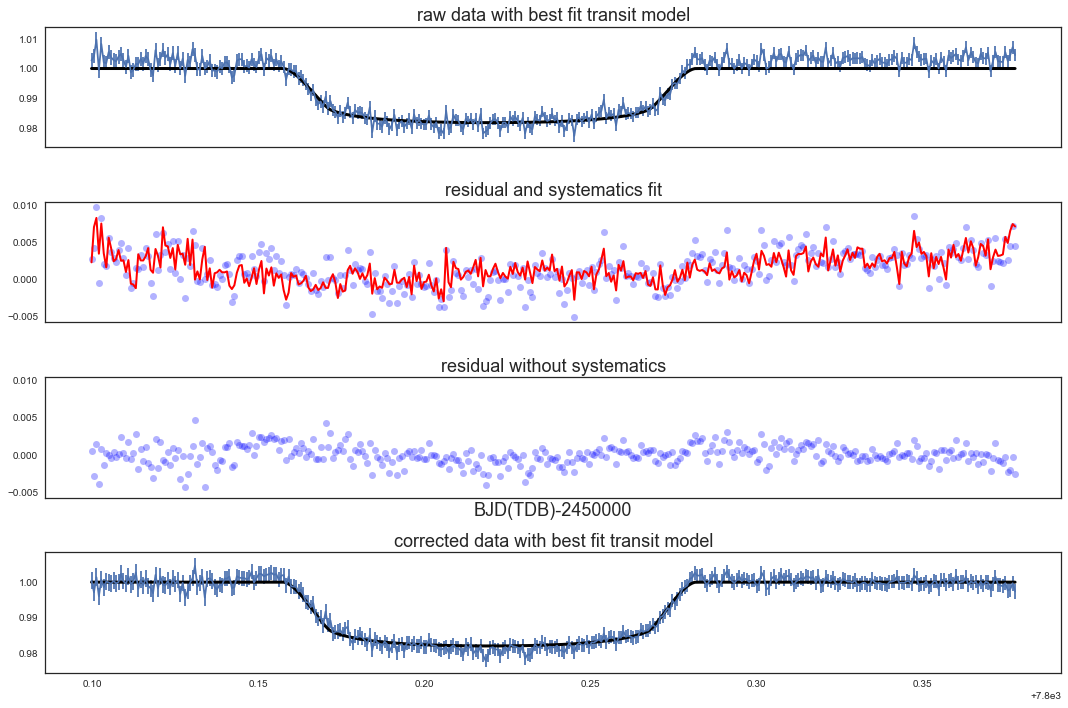

In [33]:
fig,ax = pl.subplots(4,1,figsize=(15,10), sharex=True)

#top: raw data
ax[0].errorbar(time, flux, yerr=err)
ax[0].plot(time, transit_model, 'k-', lw=3, label='model')
ax[0].set_title('raw data with best fit transit model', fontsize=fontsize)

#middle: residual
resid = flux-transit_model
ax[1].plot(time, resid, 'bo', alpha=0.3, label='residual')
ax[1].plot(time, sys_model, 'r-', lw=2, label='systematics')
ax[1].set_title('residual and systematics fit', fontsize=fontsize)

#bottom: residual without systematics
resid_wo_sys = flux-transit_model-sys_model
ax[2].plot(time, resid_wo_sys, 'bo', alpha=0.3)
ax[2].set_title('residual without systematics', fontsize=fontsize)
ax[2].set_ylim(*ax[1].get_ylim()) #make y-axis limits of ax[2] like in ax[1]
ax[2].set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)

#compute rms
rms1 = rms(flux, transit_model)
rms2 = rms(resid, resid_wo_sys)
print('rms of residual:\n{:.4f}'.format(rms1))
print('rms of residual w/o systematics:\n{:.4f}'.format(rms2))

#corrected lightcurve
ax[3].errorbar(time, flux-sys_model, yerr=err)
ax[3].plot(time, transit_model, 'k-', lw=3, label='model')
ax[3].set_title('corrected data with best fit transit model', fontsize=fontsize)
fig.tight_layout()

In [ ]:
import pandas as pd

resid_wo_sys = flux - transit_model - sys_model
pd.plotting.autocorrelation_plot(resid_wo_sys)

Although our systematics model is not perfect, using color information yields a much better fit to the residual.

---

Suppose the auxiliary vectors used above are the most useful for our systematics model. Let's create a function for this.

In [35]:
#systematics model
def systematics_model(w, aux_vec, time):
    '''
    evaluate the systematics model consisting of 
    a linear combination of constant coefficients
    and auxiliary vectors:
    
    s = w_0 = \sum X_i w_i    
    '''
    #make sure there are 6 constant coeffs
    assert len(w) == 6
    
    #unpack aux_vec
    color1, color2, dx, err = aux_vec
    
    #make sure there are 4 aux. vectors (2 are added here)
    assert len(aux_vec) == 4
       
    #add vertical offset
    vert_offset = np.ones_like(dx)
    
    #construct X
    X = np.c_[color1, color2, dx, err, vert_offset, time]
    
    #compute systematics model
    sys_model = np.dot(X,w)
        
    return sys_model

Let's test if the function works.

In [38]:
#add vertical offset
vert_offset = np.ones_like(dx)
#construct X with time
X = np.c_[color_zg, color_zr, dx, err, vert_offset, time]
#compute weights
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, resid))

#4 params in aux_vec, 2 others are added inside the systematics_model function
aux_vec = [color_zg, color_zr, dx, err]
s = systematics_model(w, aux_vec, time)

In [39]:
def find_2_bands(b):
    '''
    this function returns the 2 bands
    other than the given band
    
    e.g. if g, return r & z
    '''
    if b=='g':
        return ['r','z']
    elif b=='r':
        return ['g','z']
    elif b=='z':
        return ['g','r']
    else:
        sys.exit(1)

g-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0014

rms difference: 0.0012

r-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0012

rms difference: 0.0014

z-band
rms (resid): 0.0028
rms (resid - systematics model): 0.0013

rms difference: 0.0015



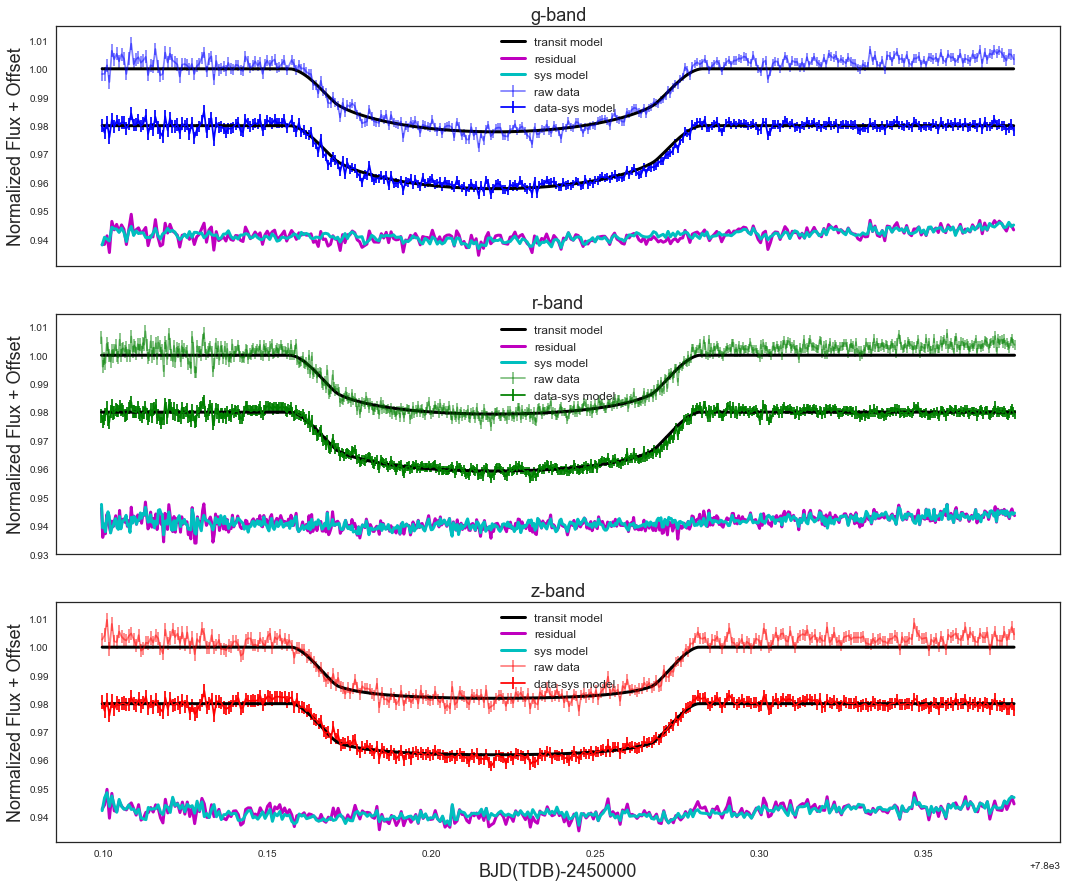

In [58]:
fig,ax = pl.subplots(3,1,figsize=(18,15), sharex=True)

X_list = {}
w_list = {}
aux_vec_list = {}

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    dx   = df['dx(pix)']
    dy   = df['dy(pix)']
    airmass = df['airmass']
    #fwhm    = df['fwhm(pix)']
    #sky     = df['sky(ADU)']
    #peak    = df['peak(ADU)']
    
    
    #plot raw data
    ax[n].errorbar(time, flux, yerr=err, label='raw data', alpha=0.5, color=c) 
    
    
    transit_params = optimized_transit_params[b]
    transit_model  = transit_model_q(transit_params, _P, time)
    
    #plot best fit transit model
    ax[n].plot(time, transit_model, 'k-', lw=3, label='transit model')
    #plot residual with offset
    resid = flux - transit_model
    ax[n].plot(time, resid+0.94, 'm-', lw=3, label='residual')
    #add resid to original dataframe
    data[b]['residual'] = resid
    
    #determine correct band
    b1,b2 = find_2_bands(b)
    
    #compute color
    color1 = flux_ratios(time,flux,data[b1].index,
                       data[b1][fluxcol], 
                       bins=len(df))
    color2 = flux_ratios(time,flux,data[b2].index,
                       data[b2][fluxcol], 
                       bins=len(df))
    #add color to original dataframe
    data[b]['color1'] = color1
    data[b]['color2'] = color2
    
    #add vertical offset
    vert_offset = np.ones_like(dx)
    
    #construct X with time
    X = np.c_[color1, color2, dx, err, vert_offset, time]
    X_list[b] = X
    
    #compute systematics model
    w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, resid))
    w_list[b] = w
    
    #supply 4 vec, 2 others addded inside systematics_model function
    aux_vec = [color1, color2, dx, err]
    aux_vec_list[b] = aux_vec
    
    #evaluate model
    sys_model = systematics_model(w, aux_vec, time)
    
    #compute rms
    rms_before = rms(flux, transit_model)
    rms_after = rms(resid,sys_model)
    print('rms (resid): {:.4f}'.format(rms_before))
    print('rms (resid - systematics model): {:.4f}\n'.format(rms_after))
    print('rms difference: {:.4f}\n'.format(rms_before-rms_after))
    
    #plot flux minus systematics
    ax[n].errorbar(time, flux-sys_model-0.02, yerr=err, 
                   label='data-sys model', alpha=1, color=c) 
    ax[n].plot(time, transit_model-0.02, 'k-', lw=3)#, label='transit model')
    
    #plot systematics model
    ax[n].plot(time, sys_model+0.94, 'c-', lw=3, label='sys model')
    
    ax[n].set_title('{}-band'.format(b), fontsize=fontsize)
    ax[n].legend(fontsize=12)
    ax[n].set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
    n+=1
    
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

Now, let's see the autocorrelations of `resid_wo_sys` (flux-transit_mode-systematics model):

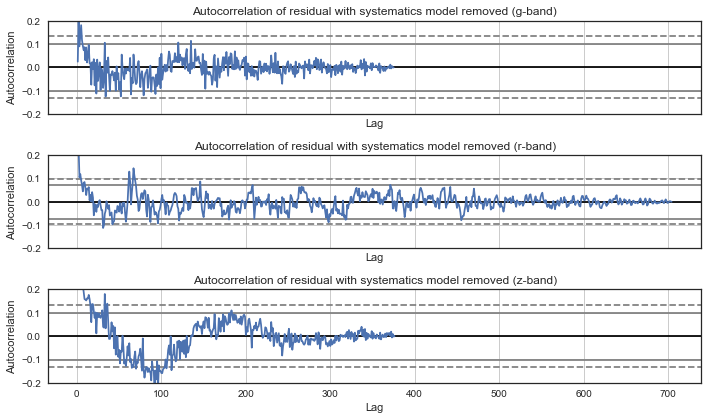

In [65]:
fig, ax = pl.subplots(nrows=3,ncols=1,figsize=(10,6), sharex=True)

n=0
for b in bands:
    df   = data[b]
    time = df.index
    
    #get residual computed earlier    
    resid = data[b]['residual']
    
    #evaluate model
    sys_model = systematics_model(w_list[b], aux_vec_list[b], time)
    
    resid_wo_sys = resid - sys_model
    pd.plotting.autocorrelation_plot(resid_wo_sys, ax=ax[n])
    ax[n].set_title('Autocorrelation of residual with systematics model removed ({}-band)'.format(b))
    ax[n].set_ylim(-0.2,0.2)
    n+=1
fig.tight_layout()

The autocorrelation of each band suggests that the residual with systematics removed cannot not be purely white noise because of the large amplitudes exceeding the dashed lines (~3 sigma).

So far, the useful auxiliary parameters we used are:
* color1, 
* color2, 
* dx, 
* err,
* vert_offset, 

Let's see their pairplot.

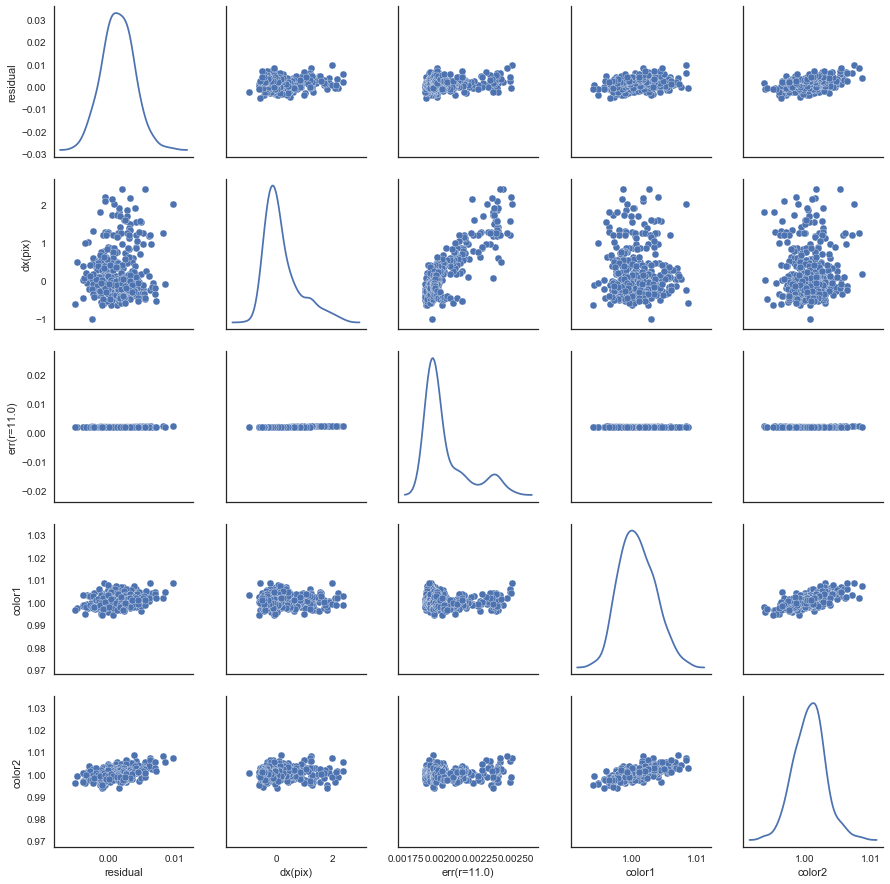

In [60]:
import seaborn as sb
sb.set_style('white')

df = data['z']
sb.pairplot(df.dropna(), vars=['residual','dx(pix)','err(r=11.0)','color1','color2'], diag_kind='kde')

# Summary

We now know how to model transit and systematics separately. In part5 of this tutorial, we will learn how to model transit and systematics simultaneously and also how to estimate the parameters better using Bayesian approach, specifically using mcmc in part6.

# Appendix

### Modeling systematics: RBF interpolation (non-parametric)

Modeling systematics (e.g. stellar variability) can also be done using radial basis function (rbf). This is usually superior than polynomial or spline fitting.

* [rbf (wiki)](https://en.wikipedia.org/wiki/Radial_basis_function)

The disadvantage of using non-parametric model like Rbf is that it works like a "black-box." As we will see below, we have a hyperparameter called `smooth` that can be set arbitrarily depending on the user.

On the other hand, the advantage of parametric modeling which implements [multiple regression](https://en.wikipedia.org/wiki/Design_matrix#Multiple_regression) technique (shown on top) where we specify reasonable auxiliary observables in $X$ is that this approach is physically-motivated. Non-parametric models however is often useful in other, more complicated cases of transit modeling. 

The results of parametric and non-parametric models are also compared below.

In [41]:
from scipy.interpolate import Rbf

#small smooth parameter is preferred
rbfi = Rbf(time, resid, smooth=1, function='multiquadric')
#rbfi = Rbf(time, resid, smooth=1, function='gaussian', epsilon=np.std(err))
variability  = rbfi(time)

Setting the `smooth` parameter depends on the user; the higher the number, the smoother. We used a very small number to model a very spiky shape of the residual. 

There are also several functions to choose from:
```
* 'multiquadric':   sqrt((r/epsilon)**2 + 1)
* 'inverse':        1.0/sqrt((r/epsilon)**2 + 1)
* 'gaussian':       exp(-(r/epsilon)**2)
* 'linear':         r
* 'cubic':          r**3
* 'quintic':        r**5
* 'thin_plate':     r**2 * log(r)
```

rms of residual:
0.0028
rms of residual w/o variability:
0.0023


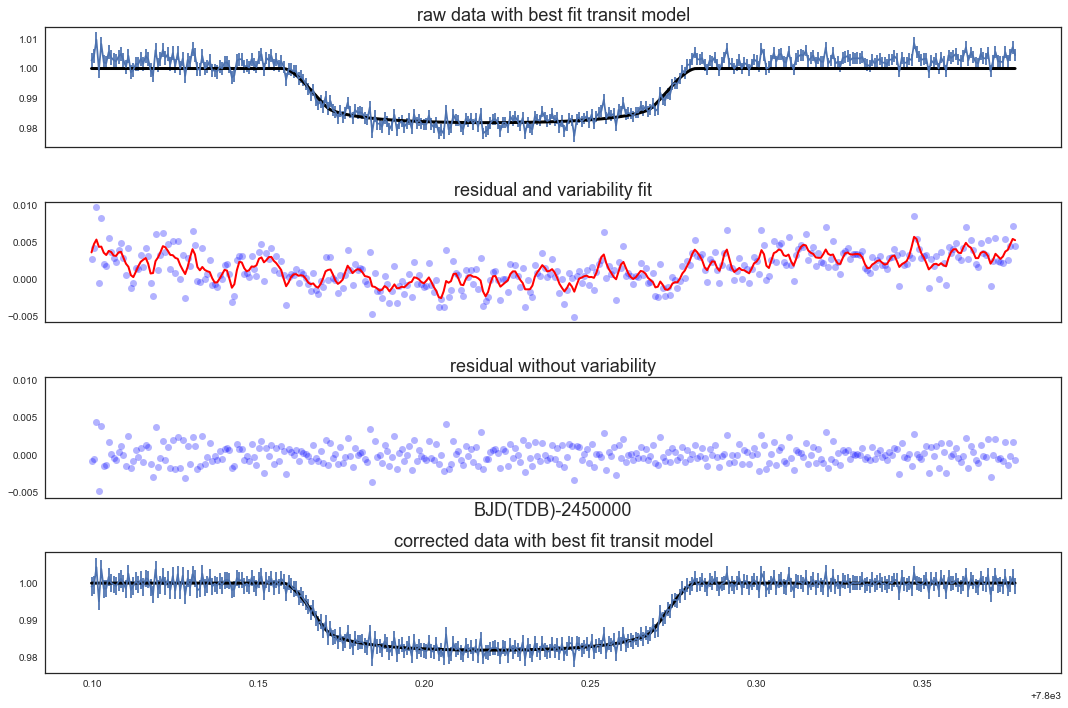

In [42]:
fig,ax = pl.subplots(4,1,figsize=(15,10), sharex=True)

#top: raw data
ax[0].errorbar(time, flux, yerr=err)
ax[0].plot(time, transit_model, 'k-', lw=3, label='model')
ax[0].set_title('raw data with best fit transit model', fontsize=fontsize)

#middle: residual
resid = flux-transit_model
ax[1].plot(time, resid, 'bo', alpha=0.3, label='residual')
ax[1].plot(time, variability, 'r-', lw=2, label='variability (rbf fit)')
ax[1].set_title('residual and variability fit', fontsize=fontsize)

#bottom: residual without variability
resid_wo_variability = flux-transit_model-variability
ax[2].plot(time, resid_wo_variability, 'bo', alpha=0.3)
ax[2].set_title('residual without variability', fontsize=fontsize)
ax[2].set_ylim(*ax[1].get_ylim()) #make y-axis limits of ax[2] like in ax[1]
ax[2].set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)

#compute rms
rms1 = rms(flux, transit_model)
rms2 = rms(resid, resid_wo_variability)
print('rms of residual:\n{:.4f}'.format(rms1))
print('rms of residual w/o variability:\n{:.4f}'.format(rms2))

#corrected lightcurve
ax[3].errorbar(time, flux-variability, yerr=err)
ax[3].plot(time, transit_model, 'k-', lw=3, label='model')
ax[3].set_title('corrected data with best fit transit model', fontsize=fontsize)
fig.tight_layout()

Let's apply Rbf fitting of systematics to all bands.

g-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0012

rms difference: 0.0014

r-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0013

rms difference: 0.0013

z-band
rms (resid): 0.0028
rms (resid - systematics model): 0.0013

rms difference: 0.0015



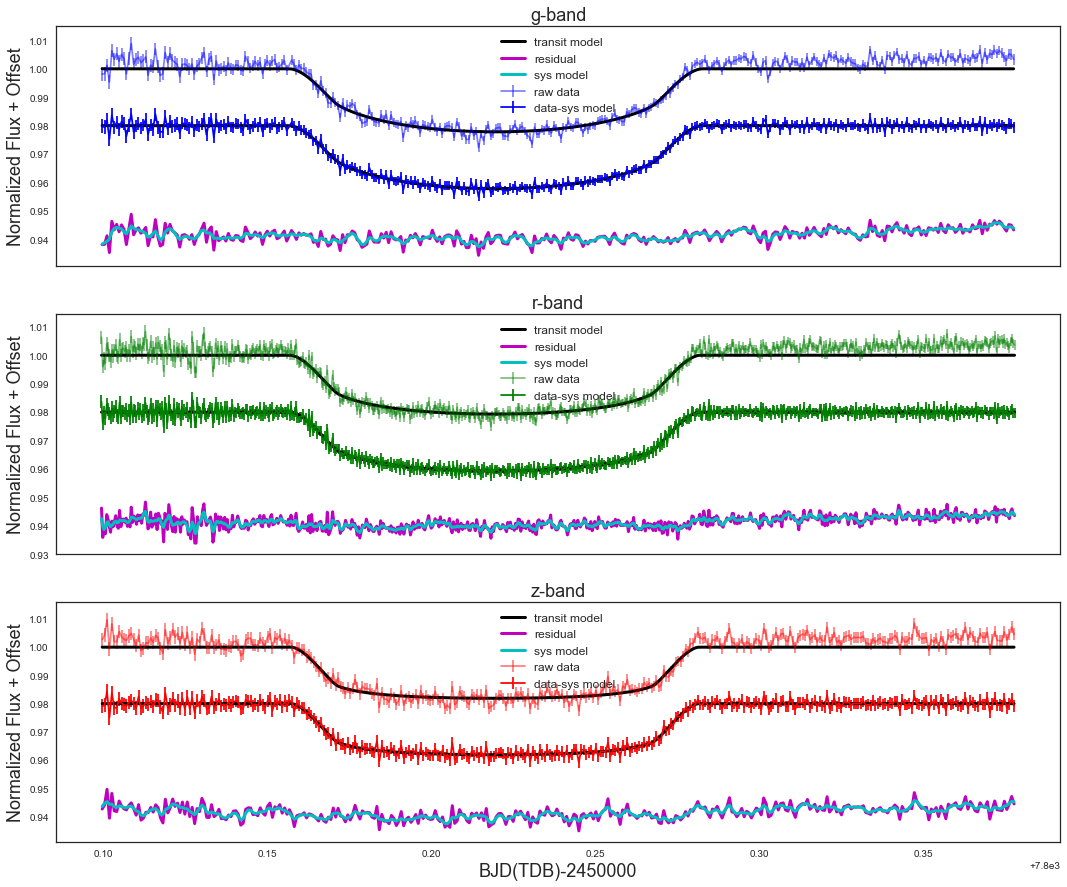

In [43]:
fig,ax = pl.subplots(3,1,figsize=(18,15), sharex=True)

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    airmass   = df['airmass']
    dx   = df['dx(pix)']
    dy   = df['dy(pix)']
    
    #plot raw data
    ax[n].errorbar(time, flux, yerr=err, label='raw data', alpha=0.5, color=c) 
    
    
    transit_params = optimized_transit_params[b]
    transit_model  = transit_model_q(transit_params, _P, time)
    
    #plot best fit transit model
    ax[n].plot(time, transit_model, 'k-', lw=3, label='transit model')
    #plot residual with offset
    resid = flux - transit_model
    ax[n].plot(time, resid+0.94, 'm-', lw=3, label='residual')
    
    
    #compute systematics model
    rbfi = Rbf(time, resid, smooth=1, function='multiquadric')
    sys_model  = rbfi(time)
    
    #rms
    rms_before = rms(flux, transit_model)
    rms_after = rms(resid,sys_model)
    print('rms (resid): {:.4f}'.format(rms_before))
    print('rms (resid - systematics model): {:.4f}\n'.format(rms_after))
    print('rms difference: {:.4f}\n'.format(rms_before-rms_after))
    
    #plot flux minus systematics
    ax[n].errorbar(time, flux-sys_model-0.02, yerr=err, 
                   label='data-sys model', alpha=1, color=c) 
    ax[n].plot(time, transit_model-0.02, 'k-', lw=3)#, label='transit model')
    
    #plot systematics model
    ax[n].plot(time, sys_model+0.94, 'c-', lw=3, label='sys model')
    
    ax[n].set_title('{}-band'.format(b), fontsize=fontsize)
    ax[n].legend(fontsize=12)
    ax[n].set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
    n+=1
    
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

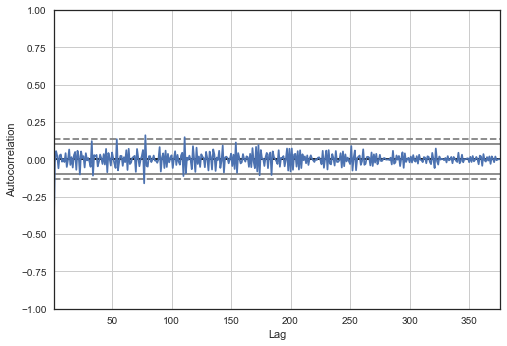

In [44]:
import pandas as pd
pd.plotting.autocorrelation_plot(resid_wo_variability)

The autocorrelation plot shows that the residual signal is random with 99% confidence (~3 sigma). The data quality of HAT-P-44b obtained by MuSCAT is exceptional. In most cases, we expect that there remains correlated ("red") noise even after the removal of stellar variability.

Note: What does `pd.plotting.autocorrelation_plot(resid)` look like?

Comparison between the results of systematics modeling using: 

(1) least-squares regression using linear algebra
```
g-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0014

rms difference: 0.0012

r-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0012

rms difference: 0.0014

z-band
rms (resid): 0.0028
rms (resid - systematics model): 0.0013

rms difference: 0.0015
```
(2) Rbf fitting
```
g-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0012

rms difference: 0.0014

r-band
rms (resid): 0.0026
rms (resid - systematics model): 0.0013

rms difference: 0.0013

z-band
rms (resid): 0.0028
rms (resid - systematics model): 0.0013

rms difference: 0.0015
```

We will use regression technique for modeling systematics because 
* regression technique is physically-motivated
* rms differences show regression technique is superior than Rbf fitting for r- and z-bands

---

## Photometric precision

Fukui-san's photometric precision achieved for HAT-P-14 (Vmag=10):
```
g                       r                     z
RMS(10s)  = 0.10%       RMS(10s)  = 0.091%    RMS(30s) = 0.068%
RMS(5min) = 0.028%      RMS(5min) = 0.022%    RMS(5min) = 0.023%
```
We can compare our results to the case of HAT-P-14 by computing the expected photometric precision for HAT-P-44 (Vmag=13.2).

$$
m_1-m_2=-2.5\log(f_1/f_2)\\
\rightarrow \frac{f_1}{f_2} = 10^{\Big(\frac{m_2-m_1}{2.5}\Big)}\\
\frac{f_1}{f_2} = 10^{\Big(\frac{13.2-10}{2.5}\Big)} = 19.9
$$
The photometric noise/ uncertainty goes with $\sqrt{\frac{f_1}{f_2}}$. Thus, the increase in the expected noise should be
$$
\sqrt{\frac{f_1}{f_2}}=4.47
$$

As will be shown below, the residual rms for g-band with 5 minute binning is 0.23%, compared to Fukui-san's 0.028%; an order of magnitude difference. We have to reduce the rms of the residual by a factor of 5 to match the photometric precisison expected for a Vmag=13 star.

In [45]:
#target rms for HAT-P-44b in g-band
0.23/5

0.046

## Interpolation/binning data points

g-band has 375 (one outlier removed) data points with 60-sec exposure time.

5-minute binning should equal to 

In [62]:
df = data['g']

#convert day to minute
obs_duration = df.index[-1] - df.index[0]

#
obs_duration*u.day.to(u.min)/len(df)

1.0674163200042677

In [63]:
len(data['g'])/5

75.0

For a 5-minute binning, the number of bins must be

In [64]:
len(data['g'])/5, len(data['r'])/9.5, len(data['z'])/5

(75.0, 74.10526315789474, 75.2)

In [65]:
bins = 75

In [71]:
def binning(x,y,bins):
    t=np.linspace(x[0],x[-1], bins)
    y=np.interp(x=t, xp=x, fp=y)
    return t,y

In [72]:
time_g, g_interpolated = binning(data['g'].index, data['g'][fluxcol].values, bins)
time_r, r_interpolated = binning(data['r'].index, data['r'][fluxcol].values, bins)
time_z, z_interpolated = binning(data['z'].index, data['z'][fluxcol].values, bins)

rms (g | 5-min bin) = 0.23%
rms (r | 5-min bin) = 0.24%
rms (z | 5-min bin) = 0.25%


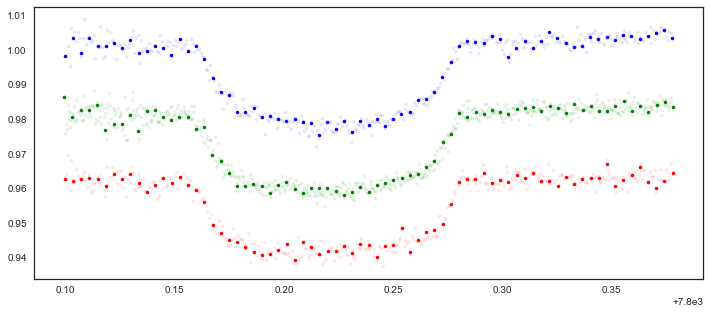

In [96]:
fig, ax = pl.subplots(1,1,figsize=(12,5))

n=0
bins = 75
for b,c in zip(bands,colors):
    df=data[b]
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    offset=n*0.02
    ax.plot(time, flux-offset,color=c,marker='.',ls='',alpha=0.1)
    
    #bin data
    time_bin, f_interpolated = binning(time, flux, bins)
    ax.plot(time_bin, f_interpolated-offset, color=c, marker='.',ls='')
    
    #compute model for binned data
    transit_model = transit_model_q(optimized_transit_params[b],_P,time_bin)
    
    print('rms ({} | 5-min bin) = {:.2f}%'.format(b, rms(f_interpolated, transit_model)*100))

    n+=1

Then, we can compute the flux ratios:

In [75]:
color_gr = g_interpolated/r_interpolated
color_rz = r_interpolated/z_interpolated
color_gz = g_interpolated/z_interpolated

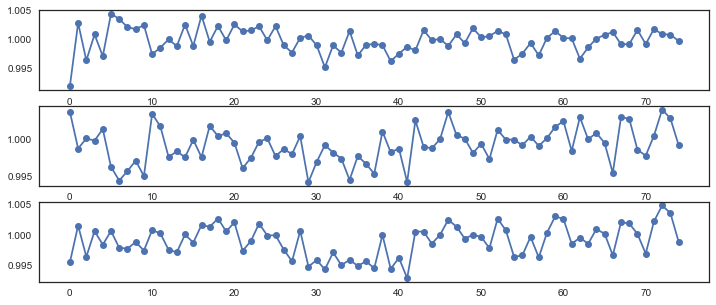

In [80]:
pl.style.use('seaborn-white')
fig,ax= pl.subplots(3,1,figsize=(12,5))

ax[0].plot(color_gr,'-o')
ax[1].plot(color_rz,'-o')
ax[2].plot(color_gz,'-o')

## second-order extinction

[Fukui et al. (2016)](https://arxiv.org/pdf/1610.01333.pdf) introduced a parameterization of baseline systematics which takes account of the second-order extinction effect. The applied function is:

$$
m_t(t) = M_{tr} + w_0 + w_tt + w_cm_c(t) + \sum w_iX_i
$$

where $m_t$ and $m_c$ are the apparent magnitudes of the target star and comparison stars, respectively, $M_{tr}$ is a transit model in magnitude scale, $t$ is time, $X_i$ is auxiliary observables such as stellar displacements on the detectors, sky backgrounds, and FWHM of the stellar PSFs, and $w_0, w_t, w_c,$ and $w_i$ are coefficients to be fitted.

## Ridge/Lasso regression

* [lasso (wiki)][1]

[1]: https://en.wikipedia.org/wiki/Lasso_(statistics)#Basic_form

## Method 1 (weighted) least-squares fitting 
### 2.1. `UnivariateSpline`

### 2.2: Least Square using Polynomial fitting

---

## Autocorrelation 

Autocorrelation is basically a correlation between a parameter and (a transformed version of) itself. We can use numpy to find the time at which correlation is highest:

In [83]:
np.correlate(resid_wo_variability,resid_wo_variability)

array([ 0.00267326])

We can use `pandas.Series.autocorr` to compute the autocorrelation with a time lag.

In [84]:
pd.Series.autocorr(resid_wo_variability, lag=10) #lag in units of 'BJD(TDB)-2450000'

0.17343661608980693

Now, let's compute the autocorrelation at all time lags (like what `pd.plotting.autocorrelation_plot` does) this time to determine the value of the smoothing parameter that gives the smallest rms error.

### optimizing `smooth` parameter in Rbf()

In [46]:
from tqdm import tqdm

#b  = 'g'
#df = data['b']

import pandas as pd

n = len(time)
lags= np.arange(0,n,1)
#smooth_params = np.linspace(0.1,100,10)
#use smaller values
smooth_params = [0.01,0.1,0.5,1,3,5,10,20,50,100]

autocorr = {} #dict with smooth as keys
autocorr_max = {} #contains 95th percentile
autocorr_med = {}

resid = flux - transit_model

#setting: hide errors
np.seterr(all='ignore')

for p in tqdm(smooth_params):
    a        = []
    key = float('{:.1f}'.format(p))
    for l in lags:
        rbfi = Rbf(time, resid, smooth=p, function='multiquadric')
        variability  = rbfi(time)
        resid_wo_variability = resid - variability
        result = pd.Series.autocorr(resid_wo_variability, lag=l)
        a.append(result)
    autocorr_med[key]=np.nanmedian(a)
    #remove nan
    mask = np.isnan(a)
    a=np.array(np.array(a)[~mask])
    #95th percentile might capture the peaks in autocorrelation
    autocorr_max[key] = np.percentile(a, 0.95)
    autocorr[key] = a

  0%|          | 0/10 [00:00<?, ?it/s]/home/jp/miniconda3/envs/astroconda35/lib/python3.6/site-packages/numpy/lib/function_base.py:3154: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
100%|██████████| 10/10 [00:34<00:00,  3.53s/it]


We need a smoothing factor whose `autocorr_max` is minimum

In [47]:
autocorr_max

{0.0: -0.68979257739404476,
 0.1: -0.58798046558951811,
 0.5: -0.58842957336195556,
 1.0: -0.61756638901203686,
 3.0: -0.57022500877879334,
 5.0: -0.54232211376507966,
 10.0: -0.51847629288061314,
 20.0: -0.52045979736490711,
 50.0: -0.52685606126715978,
 100.0: -0.53312661702820285}

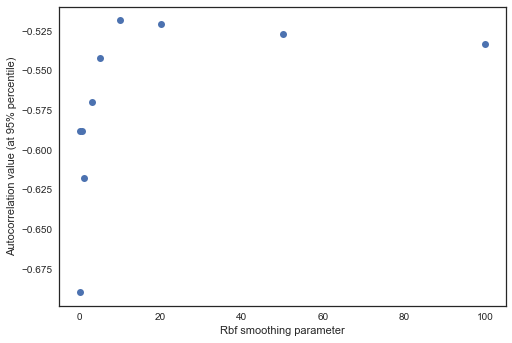

In [48]:
pl.plot(list(autocorr_max.keys()), list(autocorr_max.values()) ,'o')
pl.xlabel('Rbf smoothing parameter')
pl.ylabel('Autocorrelation value (at 95% percentile)')
#pl.xscale('log')

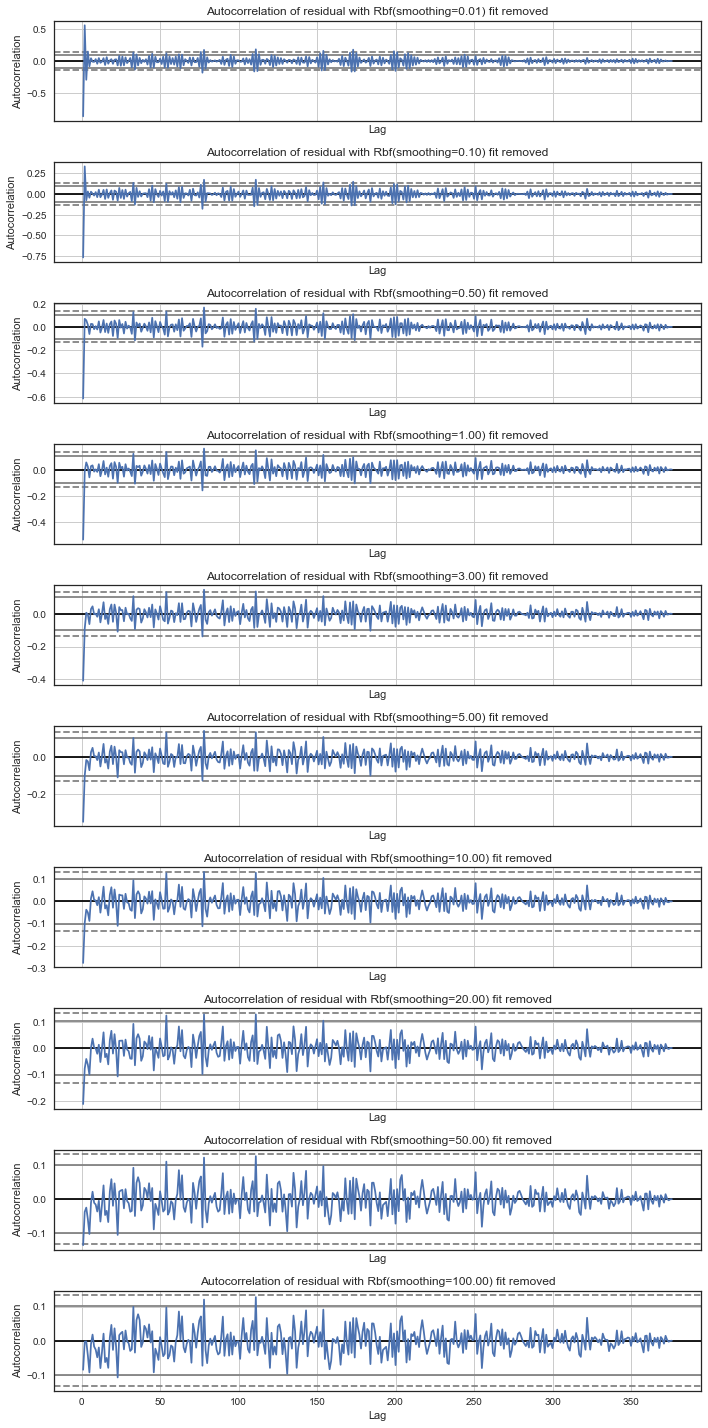

In [49]:
fig, ax = pl.subplots(nrows=len(smooth_params),ncols=1,figsize=(10,20), sharex=True)

n=0
for p in smooth_params:
    rbfi = Rbf(time, resid, smooth=p, function='multiquadric')
    variability  = rbfi(time)
    resid_wo_variability = resid - variability
    pd.plotting.autocorrelation_plot(resid_wo_variability, ax=ax[n])
    ax[n].set_title('Autocorrelation of residual with Rbf(smoothing={:.2f}) fit removed'.format(p))
    n+=1
fig.tight_layout()

To obtain the best estimates and uncertainties of the
free parameters, we performed an MCMC analysis using
a custom code (Narita et al. 2013). We first optimized
the free parameters using the AMOEBA algorithm
(Press et al. 1992), and rescaled the error bar
of each data point so that the reduced χ
2 becomes unity. 


To take into account approximate time-correlated
noises, we further inflated each error bar by a factor β,
which is the ratio of the standard deviation of a binned
residual light curve to the one expected from the unbinned
residual light curve assuming white noises alone
(Pont et al. 2006; Winn et al. 2008).

We calculated the median and 16 (84) percentile
values from the merged posterior distributions of the individual parameters. The resultant values are listed in
Table 4 and the systematics-corrected light curves along
with the best-fit transit models are shown in Figures XXX
and XXX.
